In [62]:
import csv
import os
import tensorflow as tf
import keras
from keras import layers, models
import sklearn.model_selection
import numpy as np
import math

tf.config.set_visible_devices([], 'GPU')


In [63]:

user_data = csv.DictReader(open('u.csv', encoding='utf8'))

activity_destination_pairs = []
for row in user_data:
    activities = eval(row['Preferred Activities'])
    activities = list(map(lambda activity: activity.strip(), activities))

    destinations = eval(row['Bucket list destinations Sri Lanka'])
    destinations = list(map(lambda destination: destination.strip(), destinations))

    activity_destination_pairs.append((activities, destinations))

unique_activities = list(set([activity for activities, _ in activity_destination_pairs for activity in activities]))
unique_activities.sort()

unique_destinations = list(set([destination for _, destinations in activity_destination_pairs for destination in destinations]))
unique_destinations.sort()

print(len(activity_destination_pairs), len(unique_activities), len(unique_destinations))


10000 68 157


In [64]:
review_scores_data = csv.DictReader(open('review_scores.csv', encoding='utf8'))

review_scores = {}
for row in review_scores_data:
    place_name = row['name'].strip()
    scores = eval(row['scores'])
    review_scores[place_name] = sum(scores)/len(scores)

place_data = csv.DictReader(open('p.csv', encoding='utf8'))

place_ratings = {}
for row in place_data:
    place_name = row['name'].strip()
    if not (row['rating'] and row['user_ratings_total']):
        continue

    rating = float(row['rating'])
    total_ratings = int(row['user_ratings_total'])
    total_ratings = math.log10(total_ratings)
    review_score = review_scores.get(place_name, 1)

    place_ratings[place_name] = [rating, total_ratings, review_score]

place_score_array = np.array([place_ratings[place] if place in place_ratings else [5, 0, 1] for place in unique_destinations])
place_score_array = sklearn.preprocessing.minmax_scale(place_score_array, axis=0)
# print(place_score_array)


In [65]:

def get_rating(place_index):
    rating, total_ratings, review_score = place_score_array[place_index]
    if total_ratings == 0:
        total_ratings = 1
    return rating*total_ratings*review_score


data_X = []
data_Y = []

activity_destination_weights = np.zeros(shape=(len(unique_activities), len(unique_destinations)))

for activities, destinations in activity_destination_pairs:
    for activity in activities:
        for destination in destinations:
            activity_destination_weights[unique_activities.index(activity)][unique_destinations.index(destination)] += 1

activity_destination_weights = sklearn.preprocessing.minmax_scale(activity_destination_weights, axis=1)
# print(activity_destination_weights)

for activities, destinations in activity_destination_pairs:
    X = [1 if activity in activities else 0 for activity in unique_activities]
    Ys = []
    for activity in activities:
        i = unique_activities.index(activity)
        Ys.append(activity_destination_weights[i])
    Y = np.sum(Ys, axis=0)/len(Ys[0])
    data_X.append(X)
    data_Y.append(Y)


data_X = np.array(data_X)
data_Y = np.array(data_Y)


train_X, test_X, train_Y, test_Y = sklearn.model_selection.train_test_split(data_X, data_Y, test_size=0.20)
train_X, val_X, train_Y, val_Y = sklearn.model_selection.train_test_split(train_X, train_Y, test_size=0.20)


print(len(train_X), len(val_X), len(test_X))


6400 1600 2000


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 512)               35328     
                                                                 
 dense_36 (Dense)            (None, 157)               80541     
                                                                 
Total params: 115,869
Trainable params: 115,869
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
200/200 [==============================] - 1s 2ms/step - loss: 8.3140e-04 - accuracy: 0.4634 - val_loss: 3.9152e-10 - val_accuracy: 0.9825
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 2.6728e-11 - accuracy: 0.9977 - val_loss: 6.3526e-16 - val_accuracy: 1.0000
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 3.7247e-16 - accuracy: 0.9998 - val_loss: 3.5503e-16 - val_accuracy: 

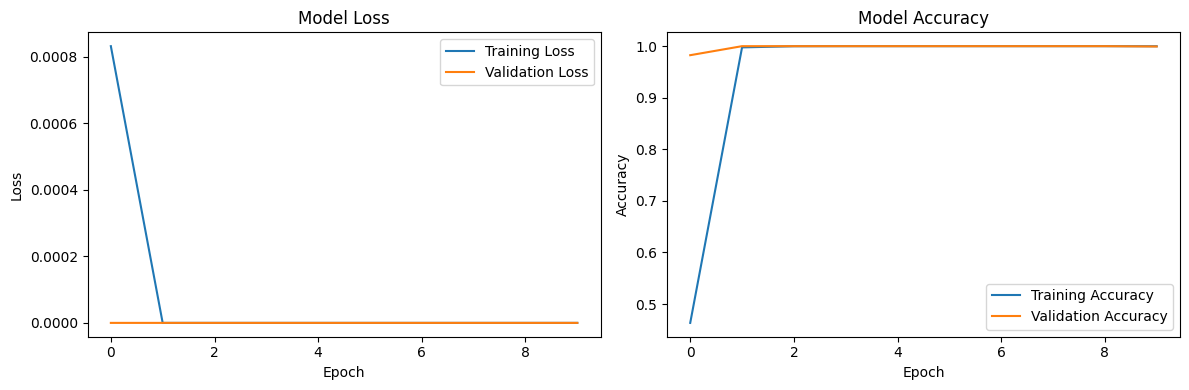

In [68]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential([
    layers.Input(shape=(len(unique_activities),)),
    layers.Dense(units=512),
    layers.Dense(units=len(unique_destinations)),
])

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

history = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=10)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
